In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from cmath import cos, sin, pi

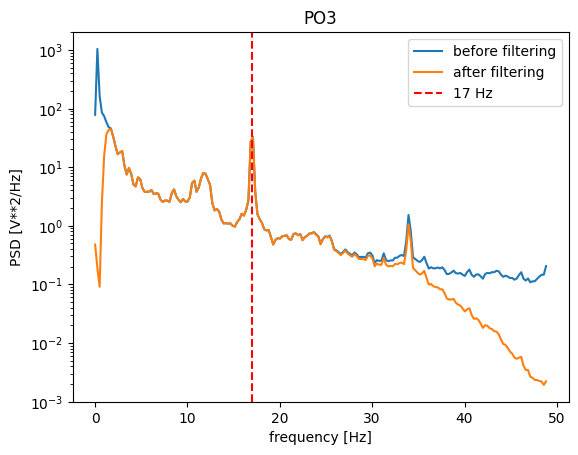

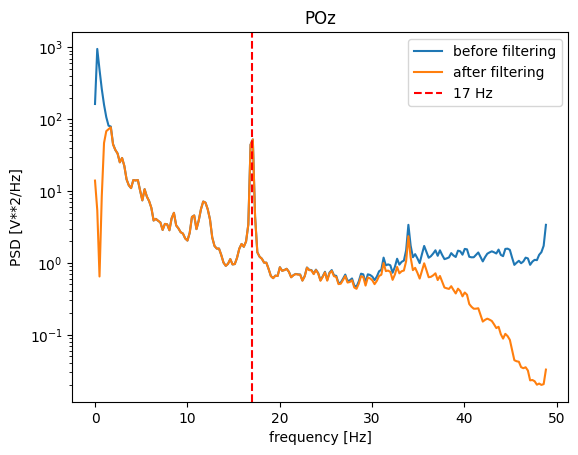

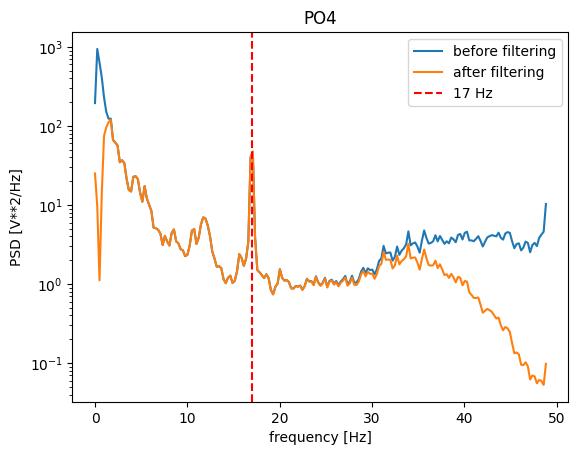

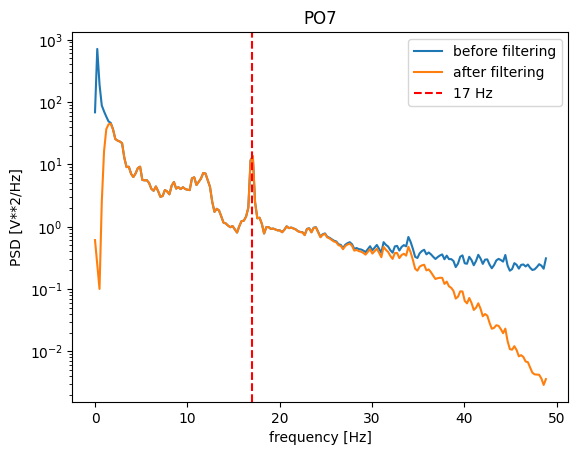

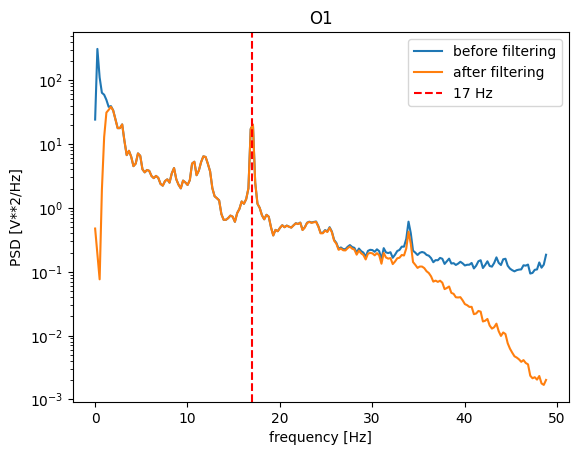

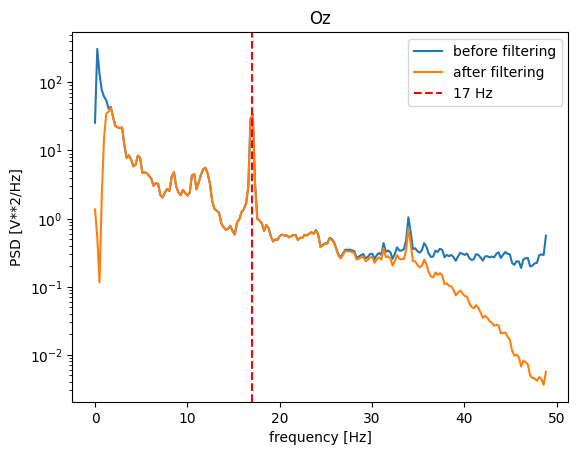

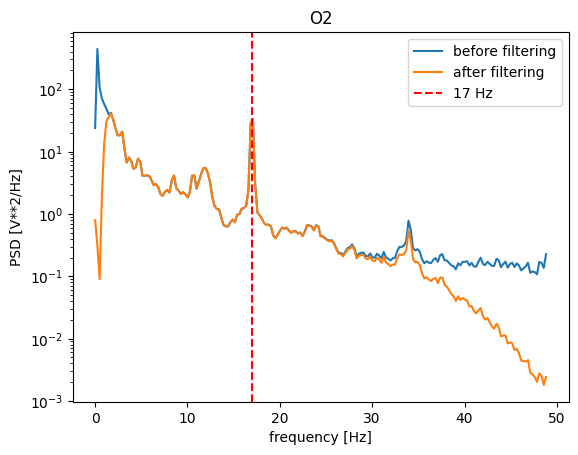

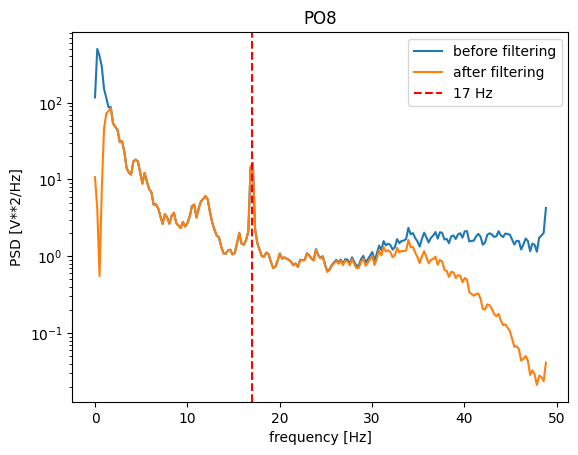

In [17]:
# Load the raw EEG data
eeg_data = pd.read_csv("data/Liuyin-5April/Morning/wet_17hz_0504_clean_ExG.csv")
chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']
# Set the sampling rate and the filter cutoff frequencies
fs = 250
low_cutoff = 1
high_cutoff = 40


#Create two dataframes from eeg_data the first is the first column which is the timestamp and the second is the remaiing columns which are the EEG data
eeg_data_timestamp = eeg_data.iloc[:,0]
eeg_data_eeg = eeg_data.iloc[:,1:]

# Create an array of the EEG data
eeg_array = eeg_data_eeg.to_numpy() # 40672 rows x 8 columns (channels)
eeg_array = eeg_array.T # 8 rows (channels) x 40672 columns (samples)

# Apply a bandpass filter to the EEG data 
b, a = signal.butter(4, [low_cutoff/(fs/2), high_cutoff/(fs/2)], btype='bandpass')
eeg_filtered = signal.filtfilt(b, a, eeg_array, axis=1)

#Plot PSD of the EEG data before and after filtering from 0-40 Hz
f, Pxx_den = signal.welch(eeg_array, fs, nperseg=1024)
f, Pxx_den_filtered = signal.welch(eeg_filtered, fs, nperseg=1024)
# Keep only the frequencies between 0 and 40 Hz
Pxx_den = Pxx_den[:,0:201]
Pxx_den_filtered = Pxx_den_filtered[:,0:201]
# Plot the PSD before and after filtering for each channel 
for i in range(8):    
    plt.figure()
    plt.semilogy(f[0:201], Pxx_den[i], label='before filtering')
    plt.semilogy(f[0:201], Pxx_den_filtered[i], label='after filtering')
    plt.xlabel('frequency [Hz]')
    # Using channel names as labels for the plots
    plt.title(chan_name[i])
    plt.ylabel('PSD [V**2/Hz]')
    # Add a white line at 17 Hz
    plt.axvline(x=17, color='red', linestyle='--', label='17 Hz')
    plt.legend()
    plt.show()




In [77]:
def rls_filter(eeg_data, target_freq, lambda_=0.98):
    # eeg_data: 2D numpy array of EEG data (channels x samples)
    # target_freq: the frequency of the target signal
    # lambda_: the forgetting factor
  
    # Initialistion:
    P = 2 # Number of filter coefficients
    delta = 1e-5
    number_samples = eeg_data.shape[0]
    # Generate the desired signal x as a sine wave with frequency target_freq
    x = np.sin(2*pi*target_freq*np.arange(0,number_samples)/fs)
    # Initialise the filter coefficients
    filter_coeffs = np.zeros([P,len(x)]) # will keep track of all the filter coefficients over time 
    # Initialise the inverse autocorrelation matrix 
    Phi_yy = delta*np.eye(P)
    eeg_hat = np.zeros([len(x),1]) # Filtered signal  
    e_rls = np.zeros([len(x),1]) # Error signal

    # Loop through the samples
    for n in range(P,number_samples):
        # Compute the input vector
        y = eeg_data[n-1:n-P-1:-1]
        print(y.shape)

        # Compute the filter output
        eeg_hat[n] = np.dot(filter_coeffs[:,n],y)
        # Compute the error signal
        e_rls[n] = x[n] - eeg_hat[n]
        # Update the inverse autocorrelation matrix
        Phi_yy = (1/lambda_)*(Phi_yy - (1/(lambda_+np.dot(np.dot(y.T,Phi_yy),y)))*np.dot(np.dot(np.dot(y.T,Phi_yy),y),Phi_yy))
        # Update the filter coefficients
        filter_coeffs[:,n] = filter_coeffs[:,n-1] + (1/lambda_)*np.dot(Phi_yy,y)*e_rls[n]
    return eeg_hat

In [78]:
rls_data = rls_filter(eeg_filtered[0], 17)

print(rls_data.shape)



(0,)


ValueError: shapes (2,) and (0,) not aligned: 2 (dim 0) != 0 (dim 0)